Guilherme Lira Ribeiro - 231013538
# Trabalho Computacional 2: Perceptron Multicamada no problema MNIST
Este caderno tem como objetivo o uso de Multi Layer Perceptron (MLP) para o problema de classificação de dígitos manuscritos MNIST. Foram testados alguns modelos que diferiram na quantidade de camadas, na função de ativação, e também nas configurações de otimização. Além disso, foram apresentadas imagens de exemplos que foram classificados erroneamente pelo modelo. Ao final, a matriz de confusão do melhor classificador, no quesito de acurácia, foi construída usando o módulo `sklearn.metrics`.


## 1. Importação de dependências e definição de classes
Para treinar os modelos, foi usada a biblioteca `pytorch`, bem como recursos da biblioteca disponibilizada pelo livro Dive into Deep Learning (`d2l`), a biblioteca `matplotlib` para a construção de gráficos e `sklearn` para a métrica de matriz de confusão.

In [25]:
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Aproveitando as classes fornecidas pelo módulo `d2l` serão definidas as classes `MNIST` e `MLP`.
A subclasse `MNIST` de `d2l.DataModule` será responsável pelo encapsulamento do carregamento e pré-processamento do *dataset* MNIST. Esta classe é responsável pela lógica de leitura dos dados, redimensionamento das imagens e conversão para tensores PyTorch.

In [2]:
class MNIST(d2l.DataModule):  #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        
        trans = transforms.Compose([
            transforms.Resize(resize),  # Imagens do tamanho 28x28
            transforms.ToTensor()       # Converte de PIL.Image para tensor
        ])
        
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)

In [3]:
dataset = MNIST()
print(len(dataset.train), len(dataset.val))
print(dataset.train.data.shape)

60000 10000
torch.Size([60000, 28, 28])


Como pode ser observado na saída da célula anterior, o dataset MNIST consiste de 60000 exemplos de treino e 10000 exemplos de validação. O tensor de treinamento é tridimensional, com cada um dos 60000 exemplos sendo uma matriz de 28 x 28. 

In [4]:
@d2l.add_to_class(MNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

Esta célula adiciona o método `get_dataloader` à classe `MNIST`. É responsável por retornar o `DataLoader` adequado para o treinamento ou validação. Organiza os dados em lotes (batches) e permite que sejam carregados de forma eficiente durante o processo de aprendizado. O argumento train define se o loader será do conjunto de treino ou validação, o que é usado internamente pelas funções `train_dataloader` e `val_dataloader`.

In [5]:
X, y = next(iter(dataset.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 28, 28]) torch.float32 torch.Size([64]) torch.int64


Na célula anterior pode-se verificar o tamanho do batch, sendo de 64 imagens, cada uma com 1 canal de cores, na escala de cinza, e dimensão 28 por 28.

### 1.2 MLP


In [6]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, hidden_sizes, lr, af='sigmoid'):
        super().__init__()
        self.save_hyperparameters()

        if af == 'sigmoid':
            activation = nn.Sigmoid
        elif af == 'relu':
            activation = nn.ReLU
        else:
            raise ValueError(f"Função de ativação '{af}' não suportada.")

        layers = [nn.Flatten()]
        for size in hidden_sizes:
            layers.append(nn.LazyLinear(size))
            layers.append(activation())
        
        layers.append(nn.LazyLinear(num_outputs))

        self.net = nn.Sequential(*layers)


A classe MLP encapsula o modelo de percéptron multicamada que será usado como classificador para o MNIST. Como modelos com diferentes configurações serão testados, o construtor da classe recebe alguns parâmetros, como `num_outputs`, que no caso sempre é 10 neste caderno, tendo em vista que é o número de classes do problema MNIST (dígitos de 0 a 9), `hidden_sizes`, que é uma lista de inteiros contendo o tamanho das camadas ocultas, e `af`, abreviação para *activation function*, que pode ser "sigmoid" ou "relu".

## 2. Funções auxiliares
Algumas funções auxiliares são úteis, como a `evaluate_accuracy`, para fornecer a métrica de acurácia dos diferentes modelos a serem treinados, e também a função `visualize_errors` e `show_confusion_matrix`. 

In [7]:
def evaluate_accuracy(model, data_iter):
	model.eval()
	metric = d2l.Accumulator(2)
	with torch.no_grad():		
		for X, y in data_iter:
			metric.add(d2l.accuracy(model(X), y), y.numel())
	model.train()
	return metric[0] / metric[1]

A função `evaluate_accuracy`, definida na célula anterior, calcula a acurácia do modelo sobre um conjunto de dados, desativando o modo de treinamento (model.eval()) para garantir comportamento consistente (como desativar dropout). Ela acumula o número total de acertos e divide pelo número total de exemplos, retornando a proporção de classificações corretas.

In [27]:
import matplotlib.pyplot as plt

def visualize_errors(model, dataset, max_errors=10):
    found_errors = 0
    images_error = []
    correct_labels = []
    predict_labels = []

    for X, y in dataset.val_dataloader():
        preds = model(X).argmax(axis=1)
        error_mask = preds != y

        if error_mask.sum() > 0:
            images_error = X[error_mask]
            y_true = y[error_mask]
            y_pred = preds[error_mask]

            for img, yt, yp in zip(images_errors, y_true, y_pred):
                images_error.append(img)
                correct_labels.append(int(yt))
                predict_labels.append(int(yp))
                found_errors += 1

                if found_errors >= max_errors:
                    break
        if found_errors >= max_errors:
            break

    for i in range(len(images_error)):
        plt.imshow(images_error[i].squeeze(), cmap='gray')
        plt.title(f"Verdadeiro: {correct_labels[i]}, Predito: {predict_labels[i]}")
        plt.axis('off')
        plt.show()

Para entender melhor os padrões que a rede falha em classificar corretamente, foram extraídas e visualizadas algumas amostras do conjunto de validação em que as previsões foram incorretas, por meio da função `visualize_errors`. A função percorre os minibatches até coletar um número fixo de erros (ex: 10), tratando corretamente casos em que um minibatch não contém erros.

Essa visualização nos permite verificar se os erros são compreensíveis também para um humano (por exemplo, 5 confundido com 6, 1 confundido com 2), o que indica limites intrínsecos dos dados e não necessariamente falhas graves do modelo.

In [28]:
def show_confusion_matrix(model, dataset):
    y_true_all = []
    y_pred_all = []

    for X, y in dataset.val_dataloader():
        preds = model(X).argmax(axis=1)
        y_true_all.extend(y.numpy())
        y_pred_all.extend(preds.numpy())

    cm = confusion_matrix(y_true_all, y_pred_all)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

    return cm

A matriz de confusão revela onde ocorrem os principais erros de classificação. Ela mostra quantas vezes cada classe verdadeira foi confundida com outra. Portanto, a função `show_confusion_matrix` é tão útil quanto `visualize_errors` para verificar se os erros estão mais relacionados ao modelo ou a limitações intrínsecas dos dados de entrada, isto é, seres humanos também poderiam razoavelmente cometer os mesmos erros de classificação.

## 3. Testando diferentes modelos
### 3.1 Uma camada oculta, sigmoide como ativação
O primeiro modelo, chamado de `model_a`, consiste em uma instância de `MLP` com uma única camada oculta, de 128 neurônios, e a função de ativação sendo a sigmoide. 

In [9]:
model_a = MLP(num_outputs=10,     # 10 classes do MNIST (Dígitos 0-9)
              hidden_sizes=[128], # 128 neurônios na camada escondida
              lr=0.1)             # Learning rate pequeno

data = MNIST(batch_size=64)

/home/guilherme/miniconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


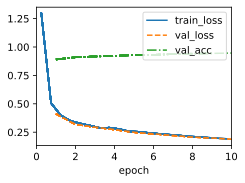

In [10]:
trainer_a = d2l.Trainer(max_epochs=10)
trainer_a.fit(model_a, data)

In [11]:
print('Acurácia de validação para modelo A: ', evaluate_accuracy(model_a, data.val_dataloader()))


Acurácia de validação para modelo A:  0.9463


Como visto nas células anteriores, o treinamento se deu em dez épocas, e o resultado obtido foi satisfatório para o primeiro modelo, com uma acurácia de 94,4%. 

### 3.2: Uma camada oculta, otimização ADAM
Nesta variação, a arquitetura básica do modelo anterior (MLP com uma camada escondida de 128 neurônios e ativação sigmoide), foi mantida, mas substituiu-se a otimização por descida de gradiente simples pelo otimizador Adam, que realiza ajustes adaptativos do *learning rate* para cada parâmetro. Essa troca visa acelerar a convergência e potencialmente melhorar o desempenho do modelo, mesmo sem alterações na estrutura da rede.

In [12]:
@d2l.add_to_class(MLP)
def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.lr)

In [13]:
model_b = MLP(num_outputs=10, hidden_sizes=[128], lr=0.001)

A célula anterior inicializa o modelo `model_b`, com uma única diferença nos parâmetros, o learning rate de 0,001, que é um valor amplamente considerado adequado para o otimizador Adam, uma vez que valores altos, como o usado no `model_a`, podem causar instabilidade no treinamento.

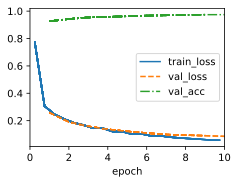

In [14]:
trainer_b = d2l.Trainer(max_epochs=10)
trainer_b.fit(model_b, data)

In [15]:
print('Acurácia de validação para modelo B: ', evaluate_accuracy(model_b, data.val_dataloader()))

Acurácia de validação para modelo B:  0.9743


Percebe-se que o modelo b é melhor que o modelo a, com uma acurácia de 97,4%, portanto, erra cerca da metade do primeiro modelo, indicando que o Adam foi mais eficaz em ajustar os pesos da rede. Essa melhora reflete a capacidade do Adam de adaptar dinamicamente a taxa de aprendizado, o que torna o treinamento mais eficiente.

### 3.3 Uma camaada oculta, função de ativação ReLU
Neste terceiro modelo, manteve-se a arquitetura com uma única camada oculta, mas a função de ativação passou de sigmoide pela ReLU (*Rectified Linear Unit*). Essa alteração visa melhorar a eficiência do treinamento e a capacidade de aprendizado, pois a ReLU costuma evitar problemas comuns da sigmoide, como o gradiente evanescente.

In [16]:
model_c = MLP(num_outputs=10, hidden_sizes=[128], lr=0.001, af='relu') 

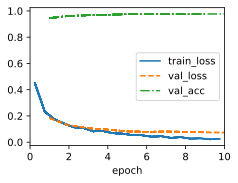

In [17]:
trainer_c = d2l.Trainer(max_epochs=10)
trainer_c.fit(model_c, data)

In [18]:
print('Acurácia de validação para modelo C: ', evaluate_accuracy(model_c, data.val_dataloader()))

Acurácia de validação para modelo C:  0.977


Como visto na célula anterior, o `model_c` atingiu a maior acurácia, embora a melhora em relação ao `model_b` tenha sido sutil. Isso reflete que as vantagens da ReLU sobre a sigmoide costumam ser mais evidentes em redes mais profundas.

### 3.4 Mais neurônios e camadas
Com os ajustes anteriores resultando em melhora da acurácia, o passo natural para tentar melhorar o modelo é o uso de uma camada oculta com mais neurônios, ou mesmo múltiplas camadas ocultas. A seguir, foram testados o `model_d` com uma camada oculta de 256 neurônios, e o `model_e` com duas camadas de 256 neurônios. No tocante as demais características, serão mantidas as do `model_c`, ou seja, ReLU como função de ativação, e o otimizador Adam.

In [19]:
model_d = MLP(num_outputs=10, hidden_sizes=[256], lr=0.001, af='relu')
model_e = MLP(num_outputs=10, hidden_sizes=[256, 256], lr=0.001, af='relu') 

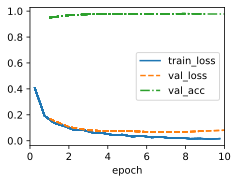

In [20]:
trainer_d = d2l.Trainer(max_epochs=10)
trainer_d.fit(model_d, data)

In [21]:
print('Acurácia de validação para modelo D: ', evaluate_accuracy(model_d, data.val_dataloader()))

Acurácia de validação para modelo D:  0.9778


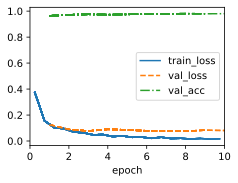

In [22]:
trainer_e = d2l.Trainer(max_epochs=10)
trainer_e.fit(model_e, data)

In [30]:
print('Acurácia de validação para modelo E: ', evaluate_accuracy(model_e, data.val_dataloader()))

Acurácia de validação para modelo E:  0.9805


# 4 Visualização e matriz de confusão
Com base na saída da avaliação de acurácia, percebe-se que o melhor modelo treinado foi o modelo E, que consiste em uma rede de duas camadas ocultas de 256 neurônios, com ReLU como função de ativação, e usando otimização Adam. Esse modelo forneceu uma acurácia de 
